In this notebook I we will verify that the GroupGLM class produces the correct likelihoods for the exponential and gaussian models.

In [1]:
#imports
from scipy.stats import norm, gamma
import numpy as np
import matplotlib.pyplot as plt
import group_glm as gm
import tensorflow as tf
from glm_utils import *

#magics
%matplotlib inline

#autoreload changes in local modules
%load_ext autoreload
%autoreload 2

In [58]:
#first we deal with the linear case, and check that our likelihood calculations are correct

mean, var, T, N, F, eps = 1, 1, 100, 1, 1, 1e-3

#generate data

data_gam = gamma.rvs(2, scale = 2, size = [T, N])

data_norm = np.random.normal(mean, var, size = [T, N])
data_norm -= np.min(data) - eps

#evaluate likelihood
gauss_likelihood = norm(np.mean(data), var).pdf(data)
exp_likelihood = gamma.pdf(data, 2, scale = 2)
gLL, eLL = sum(np.log(gauss_likelihood)), sum(np.log(exp_likelihood))



#evalutate the likelihood using the GLM objects
#gLL_, _ = gm.gaussian_GLM(np.ones([F, N]), non_lin='identity', offset_init = 0, 
#                        scale_init = 1, bias_init = 0).get_log_likelihood(data, np.mean(data)*np.ones([T, F]))
eLL_ = gm.gamma_GLM(np.ones([F, N]), non_lin='identity', offset_init = 0, 
                          scale_init = 1, bias_init = 0).get_log_likelihood(data, np.mean(data)*np.ones([T, F]))

print 'inferred likelihood: ', eLL_ , 'theoretical likelihood: ', eLL/T

inferred likelihood:  [-1.81622934] theoretical likelihood:  [-1.89166359]


In [63]:
gCDF_n = gamma.cdf(data_norm, 2, scale =  2)
nCDF_n = norm.cdf(data_norm, np.mean(data_norm), var)

gCDF_g = gamma.cdf(data_gam, 2, scale = 2)
nCDF_g = norm.cdf(data_gam, np.mean(data_gam), var)

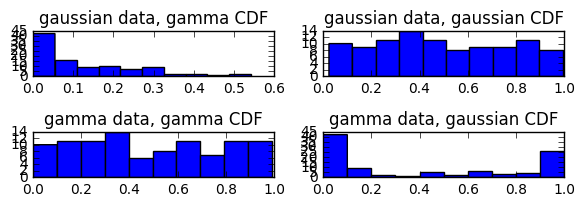

In [64]:
plt.subplot(421)
plt.hist(gCDF_n)
plt.title('gaussian data, gamma CDF')
plt.subplot(422)
plt.hist(nCDF_n)
plt.title('gaussian data, gaussian CDF')
plt.subplot(423)
plt.hist(gCDF_g)
plt.title('gamma data, gamma CDF')
plt.subplot(424)
plt.hist(nCDF_g)
plt.title('gamma data, gaussian CDF')
plt.tight_layout()

In [211]:
#now let's generate data, and again check the likelihood. 
num_neurons, num_features, T = 1, 10, 100 

stim = np.random.normal(0, scale = 1, size = [T, num_features])
weight_mat = np.zeros([num_features, num_neurons])
y = np.zeros([T, num_neurons])

for i in range(num_neurons):
    s, w, t = generate_data(T, num_features, filt_amp = np.random.uniform(5, 15), c = 3, scale = 5,
                            noise_model='gaussian', non_lin = sigmoid, stim = stim)
    weight_mat[:, i] = w   
    y[:, i] = t

    
#offset = 0
offset = np.min(y) - eps
y -= offset 

c_int = cond_int(sigmoid, weight_mat, stim, 5, 3, nls = -offset/5)

    
gLL_, var = gm.gaussian_GLM(weight_mat, non_lin = 'sigmoid', bias_init = 3,
                          offset_init = -offset / 5, scale_init = 5).get_log_likelihood(y, stim)

gLL = 1./T * sum(np.log(norm(0, var).pdf(y - c_int)))

print gLL_, gLL, var



eLL_ = gm.exponential_GLM(weight_mat, non_lin = 'sigmoid', bias_init = 3,
                          offset_init = -offset / 5, scale_init = 5).get_log_likelihood(y, stim)


eLL = 1./T * sum(np.log(gamma.pdf(y, 1, scale = c_int)))

print eLL_, eLL, 

[-1.62578772] [-1.61991548] [ 1.41605619]
[-2.39648914] [-2.30330622]
